# CL-VAE on MNIST

This is a MNIST-implementation of CL-VAE as seen in "Clustering and Anomaly Detection in financial trading data". The data used in the paper is not publicly available so I can not share it.

In [1]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
import keras
from keras import Model
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Input, concatenate
from keras.layers import LSTM, Bidirectional, GRU, Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
import pandas as pd 

In [2]:
batch_size = 100
latent_dim = 2
epochs = 100
num_classes = 10
img_dim = 28
filters = 16
intermediate_dim = 256
original_dim = 784

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

num_classes = len(np.unique(y_train))
    
    
x = Input(shape=(original_dim,), name='input_x')
h = Dense(intermediate_dim, activation='relu', name='hidden_layer')(x)

y_in = Input(shape=(num_classes,), name='input_y')

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h) 

clvae_encoder = Model(x, z_mean) 

clvae_decoder = Sequential([
                    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
                    Dense(original_dim, activation='sigmoid')
                    ], name='Decoder')


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='sampling')([z_mean, z_log_var])
x_recon = clvae_decoder(z)

class Gaussian(Layer):
    """A simple layer that computes the stats for each Gaussian outputs the mean.
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
        
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                                    shape=(self.num_classes, latent_dim),
                                    initializer='zeros')
        
    def call(self, inputs):
        z = inputs
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

gaussian = Gaussian(num_classes, name='priors')
z_prior_mean = gaussian(z)

clvae = Model([x, y_in], [x_recon, z_prior_mean])

z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)


alpha = 0.2
beta = 1.0
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(y_in, 1), kl_loss), 0)
clvae_loss = alpha * K.sum(xent_loss) + beta* K.sum(kl_loss)

clvae.add_loss(clvae_loss)
clvae.compile(optimizer='adam')
clvae.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 256)          200960      input_x[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         hidden_layer[0][0]               
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         hidden_layer[0][0]               
_______________________________________________________________________________________

In [3]:
clvae_history = clvae.fit([x_train, to_categorical(y_train)],
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, to_categorical(y_test)], None))

Epoch 1/100
600/600 [==============================] - 2s 4ms/step - loss: 7.0253 - val_loss: 6.3124
Epoch 2/100
600/600 [==============================] - 2s 4ms/step - loss: 6.2692 - val_loss: 6.2459
Epoch 3/100
600/600 [==============================] - 2s 4ms/step - loss: 6.1693 - val_loss: 6.0928
Epoch 4/100
600/600 [==============================] - 2s 4ms/step - loss: 6.0315 - val_loss: 5.9921
Epoch 5/100
600/600 [==============================] - 2s 4ms/step - loss: 5.9576 - val_loss: 5.9304
Epoch 6/100
600/600 [==============================] - 2s 4ms/step - loss: 5.8952 - val_loss: 5.8695
Epoch 7/100
600/600 [==============================] - 2s 4ms/step - loss: 5.8603 - val_loss: 5.8402
Epoch 8/100
600/600 [==============================] - 2s 4ms/step - loss: 5.8269 - val_loss: 5.8027
Epoch 9/100
600/600 [==============================] - 2s 4ms/step - loss: 5.7978 - val_loss: 5.7879
Epoch 10/100
600/600 [==============================] - 2s 4ms/step - loss: 5.7713 - val_lo

600/600 [==============================] - 2s 4ms/step - loss: 5.5160 - val_loss: 5.6115
Epoch 82/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5264 - val_loss: 5.6278
Epoch 83/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5287 - val_loss: 5.6329
Epoch 84/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5257 - val_loss: 5.6293
Epoch 85/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5242 - val_loss: 5.6348
Epoch 86/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5261 - val_loss: 5.6231
Epoch 87/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5155 - val_loss: 5.6315
Epoch 88/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5212 - val_loss: 5.6106
Epoch 89/100
600/600 [==============================] - 3s 4ms/step - loss: 5.5207 - val_loss: 5.6191
Epoch 90/100
600/600 [==============================] - 2s 4ms/step - loss: 5.5174 - val_loss: 

In [4]:
z_train_clvae = clvae_encoder.predict(x_train)
z_test_clvae = clvae_encoder.predict(x_test)
means = K.eval(gaussian.mean)
stacked_train = np.hstack([z_train_clvae, y_train.reshape(-1,1)])
stacked_test = np.hstack([z_test_clvae, y_test.reshape(-1,1)])

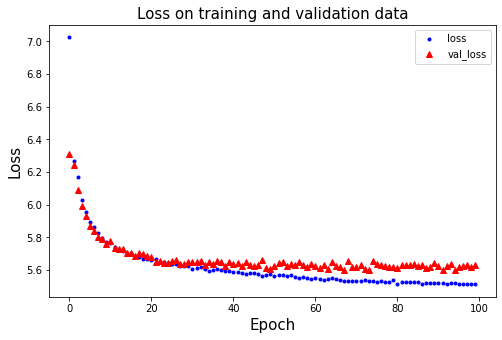

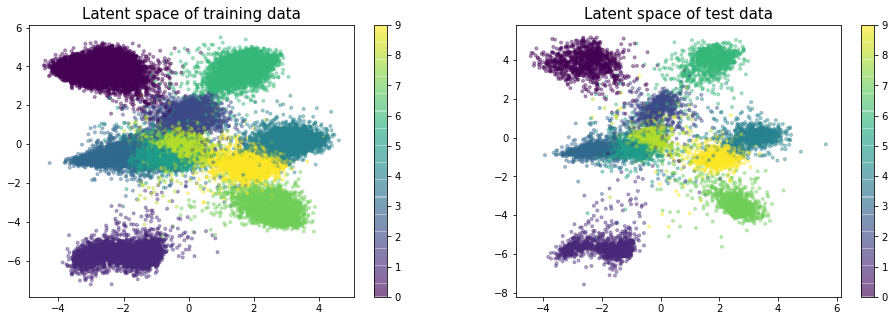

In [5]:
loss = clvae_history.history['loss']
val_loss = clvae_history.history['val_loss']
n_epochs = np.arange(epochs)

fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(111)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.title('Loss on training and validation data', fontsize=15)
ax1.plot(n_epochs, loss, 'b.', label='loss')
ax1.plot(n_epochs, val_loss, 'r^', label='val_loss')
plt.legend()
#fig1.savefig('plots/loss_vae.png')
c = np.arange(10)
temp_train = stacked_train[np.isin(stacked_train[:,-1], c)]
temp_test = stacked_test[np.isin(stacked_test[:,-1], c)]

fig2 = plt.figure(figsize=(16,5))
ax2 = fig2.add_subplot(121)
p = ax2.scatter(temp_train[:,0], temp_train[:,1], c=temp_train[:,-1], alpha=.4, s=3**2)
plt.title('Latent space of training data', fontsize=15)
fig2.colorbar(p)

ax3 = fig2.add_subplot(122)
p = ax3.scatter(temp_test[:,0], temp_test[:,1], c=temp_test[:,-1], alpha=.4, s=3**2)
plt.title('Latent space of test data', fontsize=15)
fig2.colorbar(p)
plt.savefig("cl-vae_dense_100.png")
#files.download("cl-vae_dense_100.png") 
#fig2.savefig('plots/latent_train_test_vae.png')
